# Global Surrogate
## TAIC 2 - Atividade 1

Autor: João Vitor Mergulhão

Base de dados usada na atividade: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

## Importação de Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, r2_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

## Preparação dos Dados

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "heart.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "fedesoriano/heart-failure-prediction",
  file_path)

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.


In [ ]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df['HeartDisease'].value_counts(normalize=True)

,proportion
HeartDisease,
1,0.553377
0,0.446623


In [ ]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# one-hot-encoding para lidar com as variáveis categóricas
X = pd.get_dummies(X, dtype=int)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   Sex_F              918 non-null    int64  
 7   Sex_M              918 non-null    int64  
 8   ChestPainType_ASY  918 non-null    int64  
 9   ChestPainType_ATA  918 non-null    int64  
 10  ChestPainType_NAP  918 non-null    int64  
 11  ChestPainType_TA   918 non-null    int64  
 12  RestingECG_LVH     918 non-null    int64  
 13  RestingECG_Normal  918 non-null    int64  
 14  RestingECG_ST      918 non-null    int64  
 15  ExerciseAngina_N   918 non-null    int64  
 16  ExerciseAngina_Y   918 non

## Modelo LightGBM

In [ ]:
lgbm_model = LGBMClassifier(objective='binary')
lgbm_y_pred =  cross_val_predict(lgbm_model, X, y, cv=10)

[LightGBM] [Info] Number of positive: 457, number of negative: 369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 399
[LightGBM] [Info] Number of data points in the train set: 826, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553269 -> initscore=0.213887
[LightGBM] [Info] Start training from score 0.213887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 457, number of negative: 369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGB

## Modelo de Global Surrogate - Decision Tree

In [ ]:
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3,min_samples_leaf = 10)

dt.fit(X, lgbm_y_pred)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10)

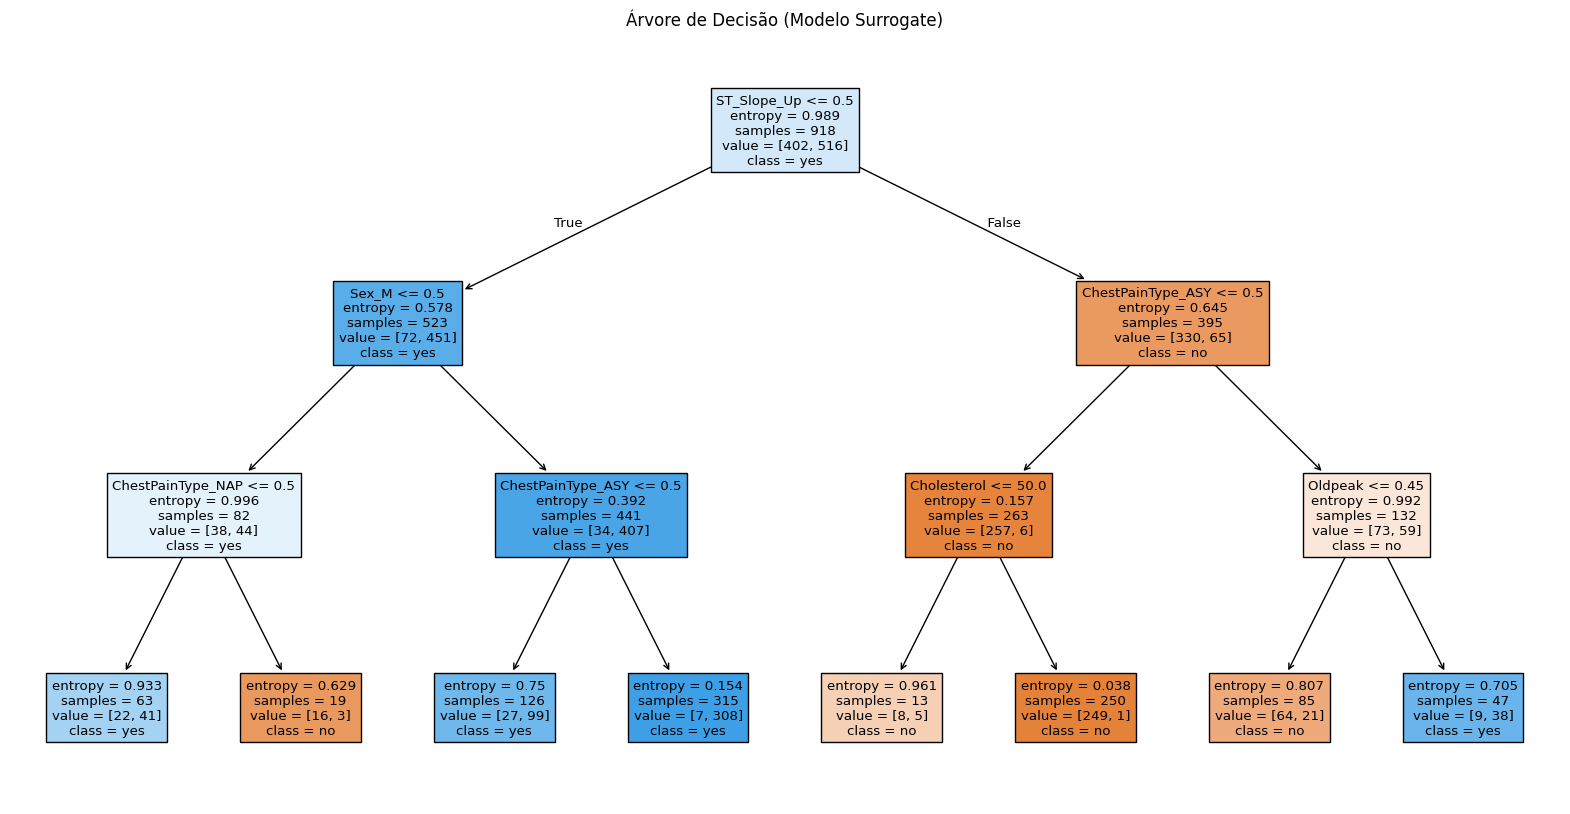

In [ ]:
plt.figure(figsize=(20, 10))

tree.plot_tree(dt,
          feature_names=X.columns,
          class_names=['no', 'yes'],
          filled=True)

plt.title("Árvore de Decisão (Modelo Surrogate)")
plt.show()

## Avaliação do Global Surrogate

In [ ]:
surrogate_y_pred = dt.predict(X)
surrogate_y_proba = dt.predict_proba(X)[:, 1]

In [ ]:
report = classification_report(lgbm_y_pred, surrogate_y_pred)
auc = roc_auc_score(lgbm_y_pred, surrogate_y_proba)

print("Relatório de Classificação:")
print(report)

print(f"O AUC do modelo é: {auc:.4f}")

r2 = r2_score(lgbm_y_pred, surrogate_y_pred)
print(f"R-squared: {r2:.4f}")

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       402
           1       0.88      0.94      0.91       516

    accuracy                           0.90       918
   macro avg       0.90      0.89      0.89       918
weighted avg       0.90      0.90      0.90       918

O AUC do modelo é: 0.9522
R-squared: 0.5796


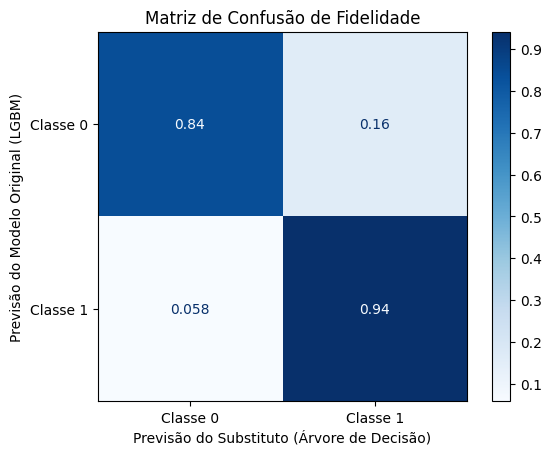

In [ ]:
# Calcular a matriz de confusão e normalizar
cm = confusion_matrix(lgbm_y_pred, surrogate_y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1'])
display.plot(cmap='Blues')

plt.xlabel('Previsão do Substituto (Árvore de Decisão)')
plt.ylabel('Previsão do Modelo Original (LGBM)')
plt.title('Matriz de Confusão de Fidelidade')
plt.show()

## Conclusão

### Análise da Visualização da Árvore

A visualização da árvore nos permite extrair as regras mais fortes e confiáveis que governam o comportamento do LGBM. Duas regras, correspondentes a folhas de baixa entropia (alta confiança), se destacam:

- Perfil de Alto Risco (Previsão: Com Doença): Pacientes com ST_Slope_Up <= 0.5 E Sex_M > 0.5 E ChestPainType_ASY > 0.5. Este é o caminho mais claro que o modelo encontrou para identificar um resultado positivo.

- Perfil de Baixo Risco (Previsão: Sem Doença): Pacientes com ST_Slope_Up > 0.5 E ChestPainType_ASY <= 0.5 E Cholesterol > 50. Esta combinação de fatores representa o sinal mais forte de um resultado negativo para o LGBM.

As outras  intermediários são menos significativos em números de amostras e apresentam uma grande mistura entre as classes.

### Análise das Métricas

A análise de fidelidade revela um comportamento claro: o alto AUC (indicando excelente ordenação das previsões) combinado ao baixo R-squared (indicando baixa correspondência exata) comprova que a árvore de decisão aprendeu com sucesso a tendência geral e a lógica de ranking do modelo LGBM, mas falhou em replicar sua fronteira de decisão precisa. Em outras palavras, o modelo substituto entende o que é importante para o LGBM, mas não consegue imitar perfeitamente onde o modelo mais complexo traça a linha final entre "doença" e "não doença".

Além disso, há um número significativo de falsos positivos, o que indica uma dificuldade da árvore de decisão de classificar como saudáveis as pessoas identificadas como não tendo doença do coração pelo LGBM.